In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

In [2]:
data = pd.read_csv('../data/superstore_cleaned.csv', parse_dates=['Order Date', 'Ship Date'])

In [3]:
recency_df = data.groupby('Customer Name', as_index=False)['Order Date'].max()
recent_date = recency_df['Order Date'].max()
recency_df['Recency'] = recency_df['Order Date'].apply(lambda x: (recent_date - x).days)
recency_df.rename(columns={'Order Date':'Last Purchase Date'}, inplace=True)

In [4]:
frequency_df = data.groupby('Customer Name', as_index=False)['Order Date'].count()
frequency_df.rename(columns={'Order Date':'Frequency'}, inplace=True)

In [5]:
monetary_df = data.groupby('Customer Name', as_index=False)['Sales'].sum()
monetary_df.rename(columns={'Sales':'Monetary'}, inplace=True)

In [6]:
rfm_df = recency_df.merge(frequency_df, on='Customer Name')
rfm_df = rfm_df.merge(monetary_df, on='Customer Name')
rfm_df['Monetary'] = rfm_df['Monetary'].round(2)
rfm_df.drop(['Last Purchase Date'], axis=1, inplace=True)

rank_df = rfm_df.copy()

In [7]:
rank_df['r_rank'] = rank_df['Recency'].rank(ascending=False)
rank_df['f_rank'] = rank_df['Frequency'].rank(ascending=False)
rank_df['m_rank'] = rank_df['Monetary'].rank(ascending=False)

rank_df['r_rank_norm'] = (rank_df['r_rank'] / rank_df['r_rank'].max()) * 100
rank_df['f_rank_norm'] = (rank_df['f_rank'] / rank_df['f_rank'].max()) * 100
rank_df['m_rank_norm'] = (rank_df['m_rank'] / rank_df['m_rank'].max()) * 100

rank_df.drop(['r_rank','f_rank','m_rank'], axis=1, inplace=True)

In [8]:
rank_df['rfm_score'] = (0.15*rank_df['r_rank_norm']) + (0.28*rank_df['f_rank_norm']) + (0.57*rank_df['m_rank_norm'])
rank_df = rank_df[['Customer Name','rfm_score']]
rank_df['rfm_score'] = round(rank_df['rfm_score']*0.05, 2)

In [9]:
top_customer_mask = (rank_df['rfm_score'] >= 4.5)
high_value_mask = ((rank_df['rfm_score']<4.5) & (rank_df['rfm_score']>=4))
medium_value_mask = ((rank_df['rfm_score']<4) & (rank_df['rfm_score']>=3))
low_value_mask = ((rank_df['rfm_score']<3) & (rank_df['rfm_score']>=1.6))
lost_mask = (rank_df['rfm_score'] < 1.6)

rank_df.loc[top_customer_mask, 'Customer Segment'] = 'Top Customer'
rank_df.loc[high_value_mask, 'Customer Segment'] = 'High Value Customer'
rank_df.loc[medium_value_mask, 'Customer Segment'] = 'Medium Value Customer'
rank_df.loc[low_value_mask, 'Customer Segment'] = 'Low Value Customer'
rank_df.loc[lost_mask, 'Customer Segment'] = 'Lost Customer'

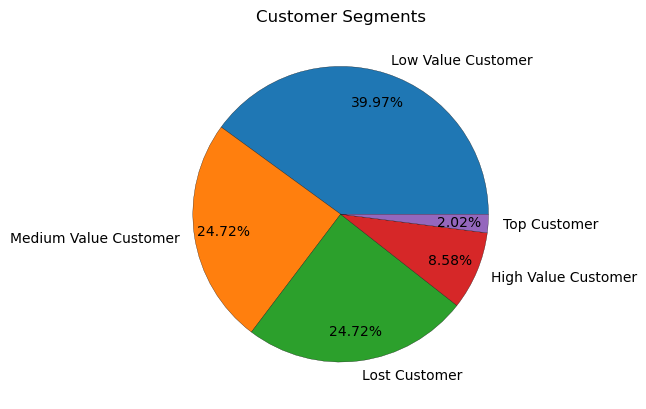

In [10]:
plt.pie(rank_df['Customer Segment'].value_counts(), labels=rank_df['Customer Segment'].value_counts().index,
       autopct='%.2f%%', pctdistance=0.8, labeldistance=1.1,
       shadow=False, wedgeprops={'edgecolor':'k','linewidth':0.2})
plt.title('Customer Segments')
plt.show()

In [ ]:
first_purchase_df = data.groupby('Customer Name', as_index=False)['Order Date'].min()
first_purchase_df.rename(columns={'Order Date':'First Purchase Date'}, inplace=True)

new_df = data.copy()
new_df = new_df.merge(first_purchase_df, on='Customer Name',how='left')
new_df['Time Since First Purchase'] = (new_df['Order Date'].max() - new_df['First Purchase Date']).dt.days

In [12]:
new_df = new_df.merge(rfm_df, on='Customer Name', how='left')
new_df = new_df.merge(rank_df, on='Customer Name', how='left')

In [13]:
churned = (new_df['Customer Segment'] == 'Lost Customer')
not_churned = (new_df['Customer Segment'] != 'Lost Customer')

new_df.loc[churned, 'Churned'] = 1
new_df.loc[not_churned, 'Churned'] = 0
new_df['Churned'] = new_df['Churned'].astype('int64')

In [14]:
new_df.rename(columns={'Churned':'Churn'}, inplace=True)

In [17]:
features = ['Recency','Frequency','Monetary','Time Since First Purchase']
target = 'Churn'

X = new_df[features]
y = new_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print(f'Accuracy: {round(accuracy,2)}')
print(classification_report(y_test, y_pred))

Accuracy: 0.94
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1231
           1       0.94      0.89      0.91       729

    accuracy                           0.94      1960
   macro avg       0.94      0.93      0.93      1960
weighted avg       0.94      0.94      0.94      1960

